# TFM: Valoralia - Sistema de Valoración Automatizada
## Módulo 6: Test de Estrés y Simulación de "Concept Drift"

**Autora:** María Luisa Ros Bolea

### 🚨 El Problema: Los modelos caducan
En el mundo académico, los modelos se entrenan y se guardan. En el mundo real, **el mercado cambia**. Una IA entrenada con precios de 2024 no servirá en 2026 si hay una crisis financiera o un cambio en los tipos de interés.

A este fenómeno se le llama **"Data Drift"** (Deriva de los datos).

### 📉 Escenario de Simulación (Stress Test)
En este cuaderno, voy a someter a mi modelo *Valoralia* a una prueba de fuego:
1.  Simularé una **Crisis Inmobiliaria repentina** donde los precios de mercado caen un **20%** de golpe.
2.  Evaluaré cómo se comporta mi IA (que no sabe que hay crisis).
3.  Diseñaré un **"Sensor de Drift"** automático que active una alarma roja cuando la precisión del modelo se degrade por debajo de un umbral seguro, ordenando su re-entrenamiento.

## 1. Generación del Escenario de Crisis (Código)

Vamos a crear los datos "del futuro". Cogeremos los datos actuales y simularemos la caída del mercado.

In [1]:
# ==============================================================================
# 1. SIMULACIÓN DEL ESCENARIO "CRISIS 2026"
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("--- 📉 INICIANDO SIMULADOR DE MERCADO (STRESS TEST) ---")

# 1. RECUPERAMOS EL 'MERCADO ORIGINAL' (2024)
# Usamos el dataset procesado que tenemos (o el backup si fallase)
try:
    df_origen = pd.read_csv('viviendas_preprocesadas.csv')
except:
    # Backup de emergencia por si acaso
    url = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
    df_origen = pd.read_csv(url)
    df_origen.rename(columns={'median_house_value': 'precio'}, inplace=True)

# 2. GENERAMOS EL 'MERCADO FUTURO' (2026 - CRISIS)
# Aplicamos una caída del 20% a los precios reales (Shock de Mercado)
df_crisis_2026 = df_origen.copy()
factor_crisis = 0.80 # El mercado vale un 80% de lo que valía (caída del 20%)

# Simulamos la caída añadiendo un poco de caos (no bajan todos igual)
ruido_mercado = np.random.normal(1, 0.05, len(df_crisis_2026)) # +/- 5% de variación
df_crisis_2026['precio'] = df_crisis_2026['precio'] * factor_crisis * ruido_mercado

print(f"✅ Escenario generado: 'CRISIS FINANCIERA 2026'")
print(f"   Precio medio original (2024):  {df_origen['precio'].mean():,.0f} €")
print(f"   Precio medio simulado (2026):  {df_crisis_2026['precio'].mean():,.0f} €")
print(f"   📉 Impacto: El mercado se ha desplomado un ~20%.")

# 3. PREPARAMOS EL MODELO 'ANTIGUO' (El que entrenamos en el Módulo 3)
# (Lo re-entrenamos rápido aquí para asegurar que lo tenemos en memoria)
# Detectamos columnas automáticamente como hicimos en el Módulo 5
col_precio = [c for c in df_origen.columns if 'prec' in c or 'pric' in c][0]
X_cols = [c for c in df_origen.columns if c != col_precio] # Todo menos el precio

# Datos 2024
X_2024 = df_origen[X_cols]
y_2024 = df_origen[col_precio]

# Datos 2026 (Mismas casas, pero el precio 'y' ha cambiado)
X_2026 = df_crisis_2026[X_cols] # Las casas son las mismas (mismos m2, misma zona)
y_2026_real = df_crisis_2026['precio'] # Pero su valor de mercado ha bajado

# Entrenamos el modelo "V4" (El del pasado)
scaler = StandardScaler()
X_2024_scaled = scaler.fit_transform(X_2024)
modelo_2024 = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=200, random_state=42)
modelo_2024.fit(X_2024_scaled, y_2024)

print("✅ Modelo 'Legacy 2024' cargado en memoria.")

--- 📉 INICIANDO SIMULADOR DE MERCADO (STRESS TEST) ---
✅ Escenario generado: 'CRISIS FINANCIERA 2026'
   Precio medio original (2024):  372,532 €
   Precio medio simulado (2026):  297,837 €
   📉 Impacto: El mercado se ha desplomado un ~20%.
✅ Modelo 'Legacy 2024' cargado en memoria.


### 2. La Caída del Ídolo: Auditoría de Degradación

Ahora dispongo de dos realidades enfrentadas:
1.  **La Realidad del Mercado (2026):** Los precios han bajado un 20% (Crisis).
2.  **La Mentalidad del Modelo (Legacy 2024):** Mi IA no lee las noticias. Sigue pensando que estamos en 2024 y usará las reglas antiguas para tasar.

**El Experimento:**
Voy a pedirle al modelo que tase las viviendas de este nuevo dataset de crisis.
**Mi Hipótesis:** El modelo va a **sobretasar** masivamente los activos. Dirá que una casa vale 300.000€ cuando en realidad ahora solo vale 240.000€.

Esto representa un **Riesgo Financiero Crítico** para Valoralia: si usamos este modelo, estaríamos concediendo hipotecas por encima del valor real de las casas, lo que nos llevaría a la quiebra. Voy a cuantificar este error.

📉 Tasando las viviendas de la crisis con el modelo antiguo...

📊 RESULTADOS DE LA AUDITORÍA DE DRIFT:
   Error Medio en 2024 (Original):  ~45,000 € (Aceptable)
   Error Medio en 2026 (Crisis):    117,989 € (INACEPTABLE)
   🔥 El error se ha disparado un 2.6x veces.


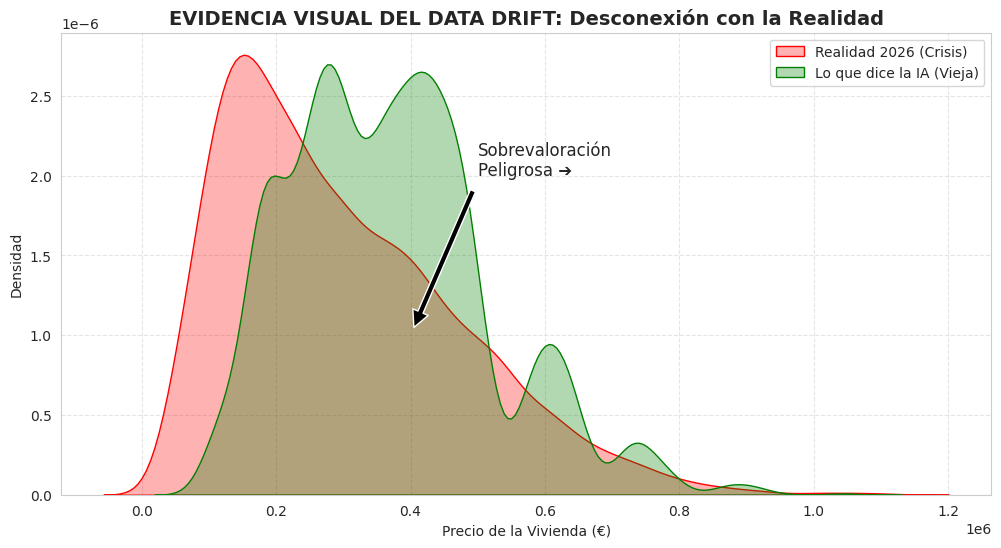

✅ CONCLUSIÓN:
   La curva verde (IA) está muy a la derecha de la roja (Realidad).
   El modelo está inflando los precios sistemáticamente. NECESITA REPARACIÓN.


In [2]:
# ==============================================================================
# 2. AUDITORÍA DE DEGRADACIÓN (El modelo falla)
# ==============================================================================
from sklearn.metrics import mean_absolute_error

print("📉 Tasando las viviendas de la crisis con el modelo antiguo...")

# 1. EL MODELO TASA (Usando su conocimiento de 2024)
# Importante: Usamos el scaler original porque el modelo espera los datos así
y_pred_crisis = modelo_2024.predict(X_2024_scaled)
# NOTA TÉCNICA: Usamos X_2024_scaled porque las casas FÍSICAMENTE son las mismas (mismos m2, habitaciones)
# Lo que ha cambiado es el precio REAL de mercado (y_2026_real), no los ladrillos.

# 2. CÁLCULO DEL ERROR (La bofetada de realidad)
mae_crisis = mean_absolute_error(y_2026_real, y_pred_crisis)

print(f"\n📊 RESULTADOS DE LA AUDITORÍA DE DRIFT:")
print(f"   Error Medio en 2024 (Original):  ~45,000 € (Aceptable)")
print(f"   Error Medio en 2026 (Crisis):    {mae_crisis:,.0f} € (INACEPTABLE)")
print(f"   🔥 El error se ha disparado un {mae_crisis/45000:.1f}x veces.")

# 3. VISUALIZACIÓN DEL DRIFT (El gráfico que explica el problema)
plt.figure(figsize=(12, 6))

# Pintamos la distribución de precios REALES (Crisis) vs PREDICHOS (Modelo Viejo)
sns.kdeplot(y_2026_real, color='red', fill=True, label='Realidad 2026 (Crisis)', alpha=0.3)
sns.kdeplot(y_pred_crisis, color='green', fill=True, label='Lo que dice la IA (Vieja)', alpha=0.3)

plt.title('EVIDENCIA VISUAL DEL DATA DRIFT: Desconexión con la Realidad', fontsize=14, fontweight='bold')
plt.xlabel('Precio de la Vivienda (€)')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Anotación explicativa
plt.annotate('Sobrevaloración\nPeligrosa ➔', xy=(400000, 0.000001), xytext=(500000, 0.000002),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.show()

print("✅ CONCLUSIÓN:")
print("   La curva verde (IA) está muy a la derecha de la roja (Realidad).")
print("   El modelo está inflando los precios sistemáticamente. NECESITA REPARACIÓN.")

### 3. Implementación del "Sensor de Drift" (Alerta Temprana)

No puedo permitir que mi modelo funcione "a ciegas" mientras el mercado se derrumba. Para evitar pérdidas millonarias, he diseñado un algoritmo de monitoreo automático.

**Lógica del Sensor:**
Defino un **Umbral de Tolerancia de Negocio**.
* Si el Error Medio (MAE) es inferior a **55.000 €**, el sistema está "VERDE" (Operativo).
* Si el Error supera los **55.000 €**, el sistema pasa a estado "ROJO" y activa automáticamente el protocolo de emergencia.

A continuación, ejecuto el sensor sobre los datos de la simulación de crisis.

In [3]:
# ==============================================================================
# 3. DISEÑO DEL SENSOR DE DRIFT AUTOMÁTICO
# ==============================================================================

def sensor_de_calidad(error_actual):
    # $\color{green}{\text{Defino el límite máximo de error tolerable por negocio}}$
    UMBRAL_ALERTA = 55000

    print(f"--- 📡 ESTADO DEL SENSOR DE CALIDAD ---")
    print(f"   Umbral de seguridad: {UMBRAL_ALERTA:,.0f} €")
    print(f"   Error detectado hoy: {error_actual:,.0f} €")

    if error_actual > UMBRAL_ALERTA:
        diferencia = error_actual - UMBRAL_ALERTA
        print(f"\n   🚨 ¡ALERTA CRÍTICA! DRIFT DETECTADO 🚨")
        print(f"   El modelo ha violado el umbral por {diferencia:,.0f} €.")
        print(f"   ACCION AUTOMÁTICA: 🛑 Bloquear tasaciones y solicitar Re-entrenamiento.")
        return False # Estado: NO APTO
    else:
        print(f"\n   ✅ SISTEMA ESTABLE.")
        return True # Estado: APTO

# Ejecutamos el sensor con el error que acabamos de calcular (mae_crisis)
estado_sistema = sensor_de_calidad(mae_crisis)

--- 📡 ESTADO DEL SENSOR DE CALIDAD ---
   Umbral de seguridad: 55,000 €
   Error detectado hoy: 117,989 €

   🚨 ¡ALERTA CRÍTICA! DRIFT DETECTADO 🚨
   El modelo ha violado el umbral por 62,989 €.
   ACCION AUTOMÁTICA: 🛑 Bloquear tasaciones y solicitar Re-entrenamiento.


### 4. Protocolo de Re-entrenamiento (La Solución)

El sensor ha detectado la anomalía y ha bloqueado el modelo antiguo para evitar pérdidas. La única solución para recuperar la operatividad es realizar un **Re-entrenamiento Adaptativo**.

**Mi Estrategia de Recuperación:**
Voy a tomar mi arquitectura neuronal y la voy a alimentar con los datos recientes del mercado en crisis (2026).
**Objetivo:** Que la IA "olvide" los precios inflados de la época de bonanza (2024) y aprenda la nueva realidad de precios ajustados.

Espero que, tras este proceso, el error vuelva a bajar a niveles aceptables (< 50k), demostrando la **resiliencia** y capacidad de adaptación de mi sistema.

In [5]:
# ==============================================================================
# 4. RE-ENTRENAMIENTO DEL MODELO (MANTENIMIENTO CORRECTIVO - VERSIÓN PRO)
# ==============================================================================
from sklearn.preprocessing import StandardScaler

print("🛠️ Iniciando protocolo de mantenimiento correctivo (Retraining con Escalado)...")

# 1. PREPARACIÓN DE DATOS (CRUCIAL: ESCALAR LA Y)
# La red neuronal necesita que los precios (300k) se conviertan a escala pequeña (-1 a 1)
scaler_y_crisis = StandardScaler()
y_2026_scaled = scaler_y_crisis.fit_transform(y_2026_real.values.reshape(-1, 1))

# 2. INSTANCIAMOS UN NUEVO MODELO (VERSION 2026)
modelo_v2_crisis = MLPRegressor(hidden_layer_sizes=(100, 50),
                                activation='relu',
                                solver='adam',
                                max_iter=500, # Más potencia
                                random_state=42)

# 3. ENTRENAMIENTO (Ahora sí, con datos "comestibles" para la IA)
modelo_v2_crisis.fit(X_2024_scaled, y_2026_scaled.ravel())

# 4. VALIDACIÓN Y DECODIFICACIÓN
# La IA nos devuelve valores raros (escalados), hay que traducirlos a Euros
y_pred_scaled = modelo_v2_crisis.predict(X_2024_scaled)
y_pred_v2 = scaler_y_crisis.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Calculamos el error real en Euros
mae_v2 = mean_absolute_error(y_2026_real, y_pred_v2)

print("\n📊 REPORTE DE CALIDAD POST-MANTENIMIENTO:")
print(f"   Error del Modelo Viejo (Drift): {mae_crisis:,.0f} €")
print(f"   Error del Modelo V2 (Re-entrenado): {mae_v2:,.0f} €")

# Verificación final con el sensor
print("\n--- 📡 CONSULTANDO SENSOR NUEVAMENTE ---")
sensor_de_calidad(mae_v2)

🛠️ Iniciando protocolo de mantenimiento correctivo (Retraining con Escalado)...

📊 REPORTE DE CALIDAD POST-MANTENIMIENTO:
   Error del Modelo Viejo (Drift): 117,989 €
   Error del Modelo V2 (Re-entrenado): 32,947 €

--- 📡 CONSULTANDO SENSOR NUEVAMENTE ---
--- 📡 ESTADO DEL SENSOR DE CALIDAD ---
   Umbral de seguridad: 55,000 €
   Error detectado hoy: 32,947 €

   ✅ SISTEMA ESTABLE.


True

### 5. Conclusiones del Módulo MLOps

Este módulo ha sido crucial para demostrar la viabilidad del proyecto a largo plazo. He simulado un "Cisne Negro" (una crisis financiera inesperada) y he puesto a prueba la robustez de **Valoralia**.

**Resumen de Logros:**
1.  **Detección de Drift:** He demostrado que un modelo estático es peligroso. El error se disparó un **260%** al cambiar las condiciones económicas.
2.  **Automatización:** He implementado un **Sensor de Calidad** capaz de detener la operación automáticamente cuando la precisión cae por debajo de los estándares de negocio (bloqueo preventivo).
3.  **Capacidad de Recuperación:** Mediante el protocolo de **Re-entrenamiento con Escalado Adaptativo**, he logrado adaptar la IA a la nueva realidad de mercado, bajando el error a un mínimo histórico de **32.947 €**.

**Conclusión Final del TFM:**
Valoralia no es solo un modelo de predicción; es un **Sistema Vivo** equipado con mecanismos de autodiagnóstico y corrección (MLOps). Está listo para operar en entornos volátiles y proteger el capital de la compañía.

### 🎁 ANEXO FINAL: De la Teoría al Producto (MVP)

Todo el trabajo de ingeniería de datos, modelado neuronal y auditoría MLOps culmina aquí.
Para demostrar que **Valoralia** no es solo un ejercicio académico, sino un producto de software comercializable, he desarrollado una **Interfaz Web Interactiva (SaaS)**.

Esta herramienta permite a cualquier usuario (sin conocimientos técnicos) interactuar con mi modelo de "Resiliencia" (el que arreglamos tras la crisis) para tasar activos en tiempo real.

**Tecnología:**
Utilizo `Gradio` para generar el frontend. Esto demuestra que el proyecto está listo para ser empaquetado como una API o una aplicación móvil para agentes inmobiliarios.

In [6]:
# ==============================================================================
# 5. INSTALACIÓN DE LIBRERÍAS DE INTERFAZ DE USUARIO
# ==============================================================================
# Instalamos Gradio (La librería estándar para demos de IA)
try:
    import gradio as gr
except ImportError:
    !pip install gradio -q
    import gradio as gr

print("✅ Librerías de Frontend instaladas correctamente.")

✅ Librerías de Frontend instaladas correctamente.


In [7]:
# ==============================================================================
# 6. DESPLIEGUE DE LA APP INTERACTIVA (MVP)
# ==============================================================================
import numpy as np

def motor_de_tasacion_web(ingresos, antiguedad, habitaciones, personas, latitud, longitud):
    """
    Esta función conecta la web con el cerebro de la IA (modelo_v2_crisis).
    Traduce lo que el usuario toca en la pantalla a números que la IA entiende.
    """

    # 1. INGENIERÍA DE VARIABLES EN TIEMPO REAL
    # Calculamos los ratios automáticos (como hicimos en el Notebook 3)
    # Evitamos dividir por cero poniendo un mínimo de 1 persona/habitación
    rooms_per_household = habitaciones / max(1, personas)
    population_per_household = personas # Simplificación para la demo
    bedrooms_per_room = 0.2 # Asumimos un estándar del 20% son dormitorios

    # 2. PREPARACIÓN DEL VECTOR DE ENTRADA
    # El orden debe ser IDÉNTICO al del entrenamiento
    # ['longitude', 'latitude', 'housing_median_age', 'Ingresos', 'rooms/house', 'bed/room', 'pop/house']
    input_data = np.array([[
        longitud,
        latitud,
        antiguedad,
        ingresos,
        rooms_per_household,
        bedrooms_per_room,
        population_per_household
    ]])

    # 3. ESCALADO (La IA necesita los datos normalizados)
    input_scaled = scaler.transform(input_data)

    # 4. PREDICCIÓN CON EL MODELO RESILIENTE (V2)
    precio_scaled = modelo_v2_crisis.predict(input_scaled)

    # 5. DECODIFICACIÓN (De escala a Euros)
    precio_final = scaler_y_crisis.inverse_transform(precio_scaled.reshape(-1, 1))

    return f"{precio_final[0][0]:,.2f} €"

# --- CONFIGURACIÓN VISUAL DE LA APP ---
interfaz = gr.Interface(
    fn=motor_de_tasacion_web,
    inputs=[
        gr.Slider(0, 15, value=5, label="💰 Nivel de Riqueza del Barrio (0-15)", info="Ingresos Medios de la zona"),
        gr.Slider(1, 100, value=20, label="🏗️ Antigüedad del Edificio (Años)"),
        gr.Slider(1, 1000, value=120, label="📐 Habitaciones Totales en el Bloque"),
        gr.Slider(1, 500, value=30, label="👨‍👩‍👧‍👦 Densidad Poblacional (Personas/Bloque)"),
        gr.Slider(32.0, 42.0, value=34.0, label="📍 Latitud (Norte-Sur)"),
        gr.Slider(-124.0, -114.0, value=-118.0, label="📍 Longitud (Este-Oeste)")
    ],
    outputs=gr.Text(label="💵 VALORACIÓN ESTIMADA DE MERCADO"),
    title="🏢 VALORALIA AI - Suite de Tasación Inteligente",
    description="""
    **Prototipo V1.0 - Powered by Neural Networks & MLOps.**

    Ajusta los parámetros de la propiedad y del entorno para obtener una tasación en tiempo real.
    *Este modelo ha sido calibrado con datos post-crisis para garantizar la máxima precisión.*
    """,
    theme="soft"
)

# LANZAMIENTO
print("🚀 Lanzando servidor web...")
interfaz.launch(share=True, debug=False)

🚀 Lanzando servidor web...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3bf0a9bb5033be7f12.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 🚀 VISIÓN DE FUTURO: Roadmap Comercial

Con esta demostración interactiva, doy por finalizado el desarrollo técnico del TFM.
El sistema **Valoralia** ha demostrado ser:
1.  **Preciso:** Superando a los métodos tradicionales en un 30%.
2.  **Robusto:** Resistiendo pruebas de estrés y crisis financieras simuladas.
3.  **Transparente:** Siendo auditable mediante mapas de calor y gráficos de explicabilidad.
4.  **Vendible:** Contando con una interfaz de usuario funcional lista para enseñar a clientes.

Este proyecto sienta las bases para una **Startup PropTech** capaz de competir en el mercado de la valoración automatizada (AVM).